In [29]:
import numpy as np
from scipy.integrate import odeint
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

## 1.1 Simulation

1. pendulum_rhs(zt, dzt, coefficients, terms) to compute the scalar product Θ(z, z˙) · Ξ
between the function terms and the coefcients at the given time points (zt, dzt). Note
that the function should be vectorized, so that (zt, dzt) can be vectors of time points.

In [3]:
def fill_theta_matrix(functions, data):
    assert type(data) == type(functions) == np.ndarray
    theta = np.zeros((data.shape[0], functions.shape[0]))
    for i in range(functions.shape[0]):
        function = functions[i]
        theta[:, i] = function(data[:, 0], data[:, 1])
    return theta

In [4]:
def pendulum_rhs(zt, dzt, coefficients, terms):
    #selected_terms =   [lambda x: terms[i]*coefficients[i] for i in range(len(terms)) if abs(coefficients[i]) > 1E-12]
    filled_theta_matrix = fill_theta_matrix(terms, np.array([zt, dzt]).T)
    return filled_theta_matrix @ coefficients.T
    

2. pendulum_ode_step(y, t, coefficients, terms) to be used as the func parameter to
scipy.integrate.odeint.

In [5]:
def pendulum_ode_step(y, t, coefficients, terms):
    zt, dzt = y
    return [dzt, *pendulum_rhs(np.array([zt]), np.array([dzt]), coefficients, terms)[0]]

3. simulate_pendulum(z0, dz0, coefficients, terms, T, dt) that uses odeint to simulate the pendulum with the initial conditions z0, z˙0 for T steps with step size ∆t.

In [6]:
def simulate_pendulum(z0, dz0, coefficients, terms, T, dt):
    t = np.linspace(0, dt * T, T)
    sol = odeint(pendulum_ode_step, np.array([z0, dz0]),t, args=(coefficients, terms))
    return sol, t

In [7]:
coeff = np.array([[-5, 0, 0, -0.25]])
terms = np.array([lambda x,y: np.sin(x), lambda x, y: x, lambda x,y: x*y, lambda x, y: y])
sol, t = simulate_pendulum(np.pi-0.1, 0, coeff,terms, 100, 0.1)

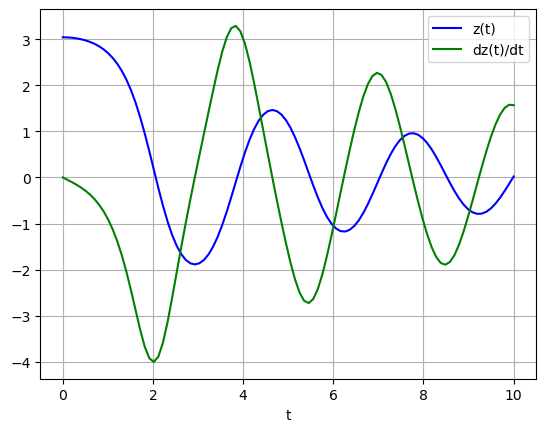

In [8]:
plt.plot(t, sol[:, 0], 'b', label='z(t)')
plt.plot(t, sol[:, 1], 'g', label='dz(t)/dt')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

This is consistent with the example results from https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html
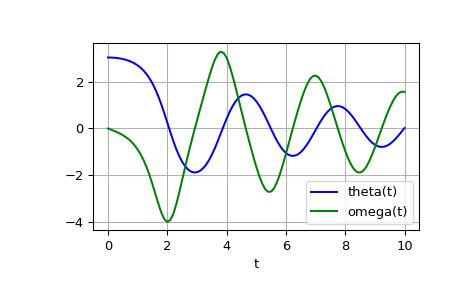

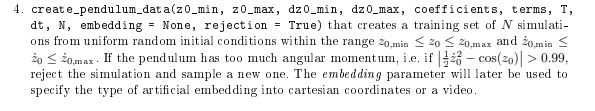

In [9]:
def create_pendulum_data(z0_min, z0_max, dz0_min, dz0_max, coefficients, terms, T, dt, N, embedding = None, rejection = True):
    dom_z = np.linspace(z0_min, z0_max, 1000)
    dom_dz = np.linspace(dz0_min, dz0_max, 1000)
    initial_conditions = []
    for i in range(N):
        generated = False
        index = 0
        while not generated:
            z_0 = np.random.choice(dom_z)
            possible_dz_indices = np.where(np.abs(0.5*dom_dz**2 - np.cos(z_0)) <= 0.99)[0]
            if len(possible_dz_indices) > 0 or index == 25:
                generated = True
            index += 1
        dz_0 = np.random.choice(dom_dz[possible_dz_indices])

        
        initial_conditions.append(np.array([z_0, dz_0]))
    initial_conditions = np.array(initial_conditions)

    ts = []
    for z_0, dz_0 in initial_conditions:
        sol, t = simulate_pendulum(z_0, dz_0, coefficients, terms, T, dt)
        ddz = pendulum_rhs(sol[:, 0], sol[:, 1], coefficients, terms)
        ts.append(np.array([sol[:, 0], sol[:, 1], ddz[:, 0]]))
    return np.array(ts)
        
        
                              

In [10]:
coeff = np.array([[-1, 0, 0, 0]])
terms = np.array([lambda x,y: np.sin(x), lambda x, y: x, lambda x,y: x*y, lambda x, y: y])
data = create_pendulum_data(-1, 1, -1, 1, coeff, terms, 500, 0.02, 2, embedding = None, rejection = True)
coeff = np.array([[-1, 0, 0, -0.05]])
dampened_data = create_pendulum_data(-1, 1, -1, 1, coeff, terms, 5000, 0.02, 2, embedding = None, rejection = True)
dampened_data.shape

(2, 3, 5000)

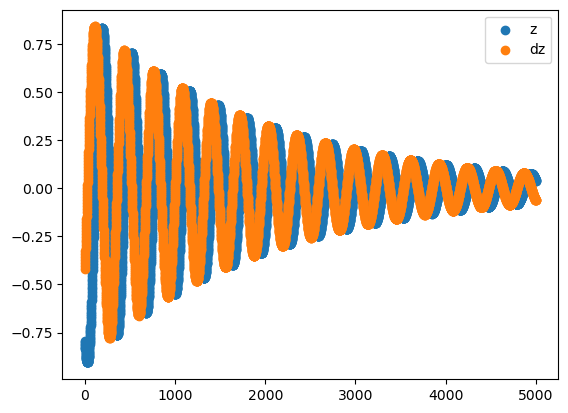

In [42]:
plt.scatter(range(5000), dampened_data[0][0], label="z")
plt.scatter(range(5000), dampened_data[0][1], label="dz")
plt.legend()

## 2.1 Cartesian Embedding

In [12]:
def embed_cartesian(z, dz, ddz):
    x = np.array([np.sin(z), -np.cos(z)])
    dx =  np.array([np.cos(z) * dz, np.sin(z)*dz])
    ddx =  np.array([-np.sin(z) * dz**2 + np.cos(z)*ddz, np.cos(z)*dz**2+np.sin(z)*ddz])
    return np.array([x,dx,ddx])

## 1.1

In [13]:
def create_phase_plot(data):
    fig, axs = plt.subplots(len(data), 3, constrained_layout=True)
    fig.suptitle("Phase portrait", fontsize="x-large")
    for i in range(len(data)):
        simulation = data[i]
        coords = embed_cartesian(*simulation)
        axs[i, 0].scatter(coords[0, 0, :], coords[1, 0, :], s=0.1)
        axs[i, 0].set_xlabel("Position in x")
        axs[i, 0].set_ylabel("Velocity")
        axs[i, 1].scatter(coords[0, 1, :], coords[1, 1, :], s=0.1)
        axs[i, 1].set_xlabel("Position in y")
        axs[i, 1].set_ylabel("Velocity")
        axs[i, 2].scatter(simulation[0, :], simulation[1, :], s=0.1)
        axs[i, 2].set_xlabel("z")
        axs[i, 2].set_ylabel("dz")
    plt.show()

C:\Users\Florian\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


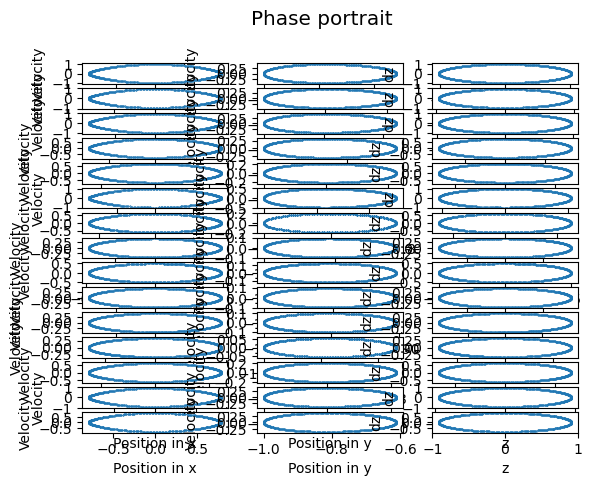

In [380]:
create_phase_plot(data)

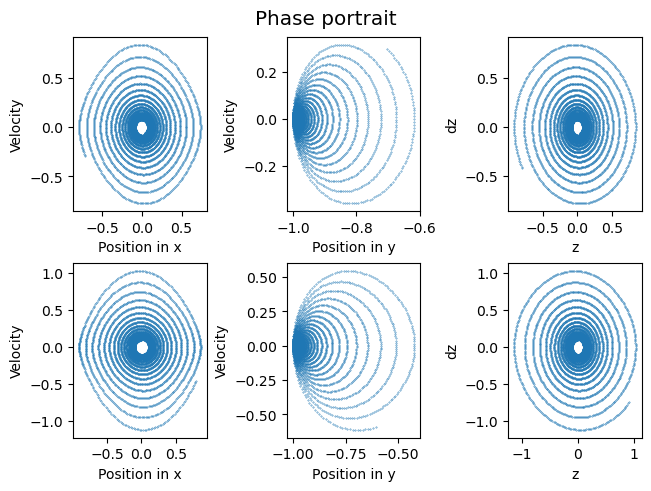

In [381]:
create_phase_plot(dampened_data)

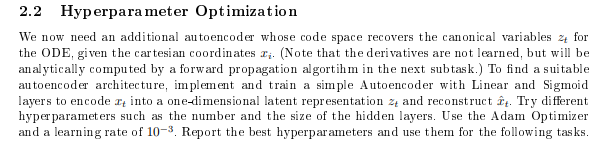

In [14]:
class VariableAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, layers, activation="ReLU"):
        assert activation =="ReLU" or activation == "sigmoid"
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.layers = layers
        
        self.activation = activation
        self.encoder = [] 
        self.decoder = []
        self.encoder.append(nn.Linear(self.input_size, self.hidden_size))
        if activation == "ReLU":
            self.encoder.append(nn.ReLU())
        self.decoder.append(nn.Linear(1, self.hidden_size))
        if activation == "ReLU":
            self.encoder.append(nn.ReLU())
        
        
        for layer in range(self.layers - 1):
            self.encoder.append(nn.Linear(self.hidden_size, self.hidden_size))
            self.decoder.append(nn.Linear(self.hidden_size, self.hidden_size))
            
            if activation == "ReLU":
                self.encoder.append(nn.ReLU())
                self.decoder.append(nn.ReLU())
            
            if activation == "sigmoid":
                self.encoder.append(nn.Sigmoid())
                self.decoder.append(nn.Sigmoid())
        
        self.encoder.append(nn.Linear(self.hidden_size, 1))
        self.decoder.append(nn.Linear(self.hidden_size, self.input_size))
        
        self.encoder = nn.Sequential(*self.encoder)
        self.decoder = nn.Sequential(*self.decoder)
        
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        return self.decode(self.encode(x))
        

    

In [441]:
coeff = np.array([[-1, 0, 0, 0]])
terms = np.array([lambda x,y: np.sin(x), lambda x, y: x, lambda x,y: x*y, lambda x, y: y])
data = np.array(create_pendulum_data(-1, 1, -1, 1, coeff, terms, 1000, 0.02, 15, embedding = None, rejection = True))

def create_train_test_set(data, p_train, p_test):
    assert p_train >= 0 and p_test >= 0  and p_train + p_test == 1
    data = np.array([embed_cartesian(*simulation) for simulation in data])
    #np.random.shuffle(data)
    data = np.concatenate(data, axis=2).T
    data_train, data_test = train_test_split(data, test_size = p_test, train_size=p_train)
    return data_train, data_test
data_train, data_test = create_train_test_set(data, 0.4, 0.6)

In [305]:
data_train.shape

(400, 2, 3)

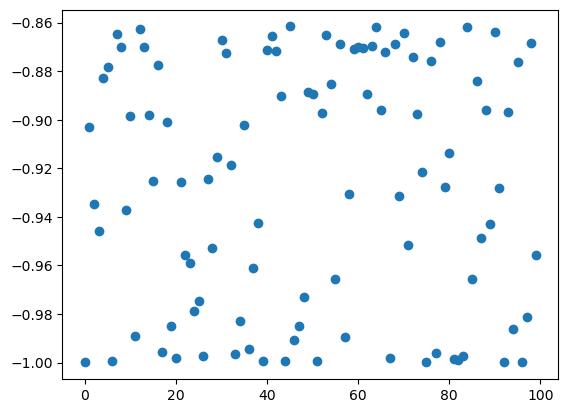

In [306]:
plt.scatter(range(100), data_train[:100, 1, 0])

In [307]:
np.concatenate(data, axis=1).shape

(3, 1000)

In [308]:
data_test.shape

(600, 2, 3)

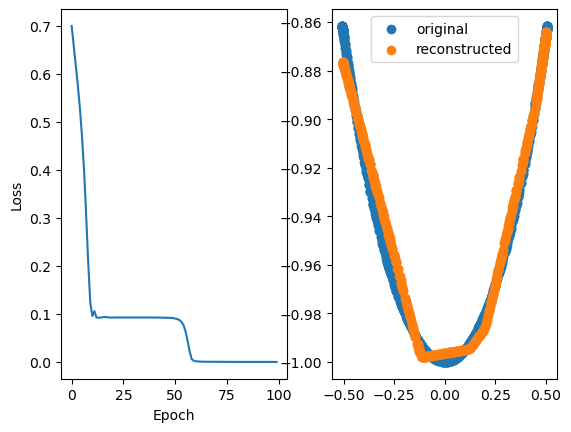

In [309]:
def calc_loss(model, data, criterion):
    outputs = model(data)
    loss = criterion(outputs, data)
    return loss

def train_auto_encoder(autoencoder, train_data, num_epochs, lr=0.001):
    X = torch.FloatTensor(train_data)#.reshape(-1, train_data.shape[0] * train_data.shape[2]).T)
    dataset = TensorDataset(X)
    data_loader = DataLoader(dataset, batch_size=64, shuffle=False)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    loss_list=[]
    for epoch in range(num_epochs):
        for data in data_loader:
            inputs = data[0]
            loss = calc_loss(model, inputs, criterion)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        loss_list.append(loss.item())

    return loss_list


model = VariableAutoencoder(2, 15, 5, "ReLU")
num_epoch = 100
loss_list = train_auto_encoder(model, data_train[:, :, 0], num_epoch)
reconstructed_test_data = model.forward(torch.FloatTensor(data_test[:, :, 0])).detach().numpy()#.reshape(-1, data_test.shape[0] * data_test.shape[2]).T)).detach().numpy()
# Plot loss
fig, axs = plt.subplots(1, 2)
axs[0].plot(range(num_epoch), loss_list, label='Training Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')

axs[1].scatter(data_test[:, 0, 0], data_test[:, 1, 0], label="original")
axs[1].scatter(reconstructed_test_data[:, 0], reconstructed_test_data[:, 1], label="reconstructed")

plt.legend()
plt.show()


## 2.3 Propagation of Time Derivates

In [310]:
class LinearDerivatives(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.layer = nn.Linear(input_size, output_size)
    
    def forward(self, X):
        x, dx, ddx = X[:, :, 0], X[:, :, 1], X[:, :, 2]

        z = self.layer(x)
        dz = self.layer(dx) - self.layer.state_dict()['bias']
        ddz = self.layer(ddx) - self.layer.state_dict()['bias']
        return torch.stack([z.T, dz.T, ddz.T]).T
        
    

In [311]:
class SigmoidDerivatives(nn.Module):
    def __init__(self):
        super().__init__()
    
    def der2_sigmoid(self, x):
        return self.der_sigmoid(x) * (2 - self.der_sigmoid(x))
    
    def der_sigmoid(self, x):
        return nn.functional.sigmoid(x) * (1 - nn.functional.sigmoid(x))
    
    def forward(self, Z):
        z_t, dz_t, ddz_t = Z[:, :, 0], Z[:, :, 1], Z[:, :, 2]
        z = nn.functional.sigmoid(z_t)
        dz = self.der_sigmoid(z_t) * dz_t
        ddz = (self.der2_sigmoid(z_t) * dz_t) * dz_t + self.der_sigmoid(z_t) * ddz_t
        return torch.stack([z.T, dz.T, ddz.T]).T
        
    

In [390]:
class VariableAutoencoderWithDerivatives(nn.Module):
    def __init__(self, input_size, hidden_size, layers):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.layers = layers

        self.encoder = [] 
        self.decoder = []
        self.encoder.append(LinearDerivatives(self.input_size, self.hidden_size))
        #self.encoder.append(SigmoidDerivatives())
        
        #self.decoder.append(SigmoidDerivatives())
        self.decoder.append(LinearDerivatives(1, self.hidden_size))
        #self.decoder.append(SigmoidDerivatives())
        
        
        for layer in range(self.layers - 1):
            self.encoder.append(LinearDerivatives(self.hidden_size, self.hidden_size))
            self.decoder.append(LinearDerivatives(self.hidden_size, self.hidden_size))
            
            self.encoder.append(SigmoidDerivatives())
            self.decoder.append(SigmoidDerivatives())
        
        self.encoder.append(LinearDerivatives(self.hidden_size, 1))
        self.decoder.append(LinearDerivatives(self.hidden_size, self.input_size))
        
        self.encoder = nn.Sequential(*self.encoder)
        self.decoder = nn.Sequential(*self.decoder)
        
    
    def encode(self, x):
        return self.encoder.forward(x)
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        return self.decode(self.encode(x))
        

    

(9000, 2, 3)


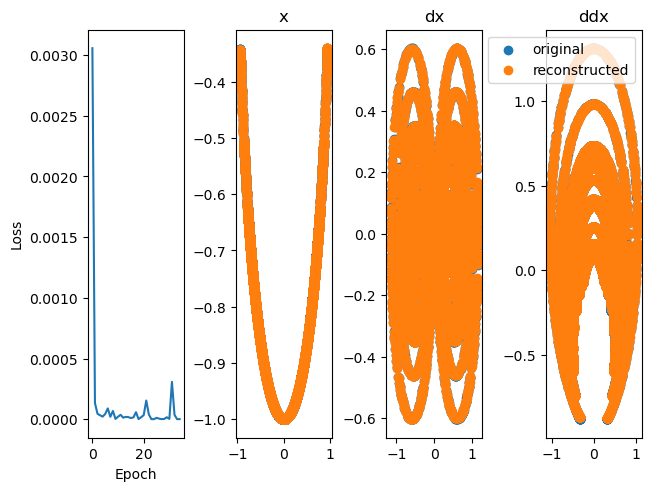

In [442]:
model = VariableAutoencoderWithDerivatives(2, 250, 3)
num_epoch = 35
loss_list = train_auto_encoder(model, data_train, num_epoch)



reconstructed_test_data = model.forward(torch.FloatTensor(data_test)).detach().numpy()#.reshape(-1, data_test.shape[0] * data_test.shape[2]).T)).detach().numpy()
# Plot loss
fig, axs = plt.subplots(1, 4, constrained_layout=True)
axs[0].plot(range(num_epoch), loss_list, label='Training Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
print(data_test.shape)
axs[1].set_title("x")
axs[1].scatter(data_test[:, 0, 0], data_test[:, 1, 0], label="original")
axs[1].scatter(reconstructed_test_data[:, 0, 0], reconstructed_test_data[:, 1, 0], label="reconstructed")

axs[2].set_title("dx")
axs[2].scatter(data_test[:, 0, 1], data_test[:, 1, 1], label="original")
axs[2].scatter(reconstructed_test_data[:, 0, 1], reconstructed_test_data[:, 1, 1], label="reconstructed")


axs[3].set_title("ddx")
axs[3].scatter(data_test[:, 0, 2], data_test[:, 1, 2], label="original")
axs[3].scatter(reconstructed_test_data[:, 0, 2], reconstructed_test_data[:, 1, 2], label="reconstructed")

plt.legend()
plt.show()

In [427]:
z_test = model.encoder(torch.FloatTensor(data_test)).detach().numpy()

In [429]:
def finite_differences_first_order(x, dt):
    x_dot = []
    for i in range(1, len(x) - 1):
        x_dot.append((x[i+1] - x[i-1]) / (2* dt))
    return x_dot

In [430]:
def finite_differences_second_order(x, dt):
    x_ddot = []
    for i in range(1, len(x) - 1):
        x_ddot.append((x[i-1]  -2*x[i] + x[i+1]) / (dt**2))
    return x_ddot

In [488]:
z_dot = finite_differences_first_order(z_test[:, :, 0], 0.6)

In [489]:
z_ddot = finite_differences_second_order(z_test[:, :, 0], 2)

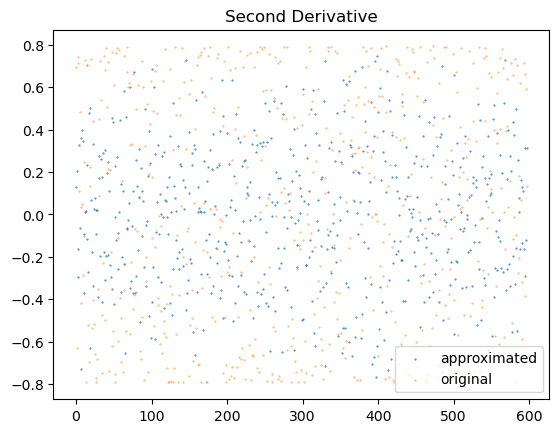

In [490]:
plt.title("Second Derivative")
plt.scatter(range(len(z_dot)), z_ddot, s=0.2, label="approximated")
plt.scatter(range(len(z_dot)), z_test[1:-1, :, 1], s=0.1, label="original")
plt.legend()

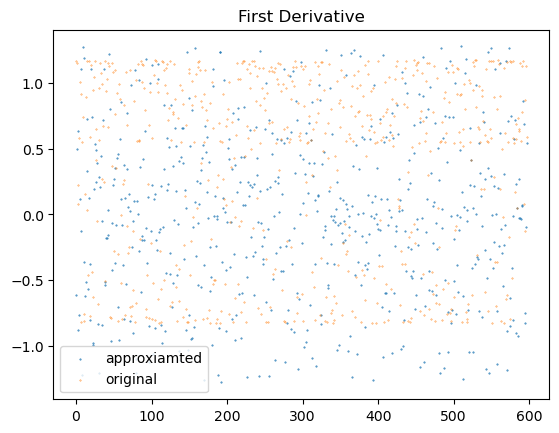

In [491]:
plt.title("First Derivative")
plt.scatter(range(len(z_dot)), z_dot, s=0.2, label="approxiamted")
plt.scatter(range(len(z_dot)), z_test[1:-1, :, 2], s=0.1, label="original")
plt.legend()

Since the step size $\Delta$t is not known in z-space, it is hard to approximate the derivatives. Also since both derivatives dont follow obvious patterns, it is also hard to compare the computed derivative with the derivatives from the auto encoder. 